In [6]:
class DecisionNode:
    def __init__(self, gini=0, num_samples=0, num_samples_per_class=None, predicted_class=None, feature_index=0, threshold=0, left=None, right=None):
        self.gini = gini
        self.num_samples = num_samples
        self.num_samples_per_class = num_samples_per_class
        self.predicted_class = predicted_class
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right

class DecisionTreeClassifier:
    def __init__(self, max_depth=None, min_samples_split=2, min_samples_leaf=1):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.root = None

    @staticmethod
    def _gini(y):
        m = len(y)
        return 1.0 - sum((np.sum(y == c) / m) ** 2 for c in np.unique(y))


    def _grow_tree(self, X, y, depth=0):
        # Stopping conditions: if the number of samples is less than the minimum number for a leaf
        # or if we have reached the maximum depth specified
        if len(y) < self.min_samples_leaf or (self.max_depth is not None and depth >= self.max_depth):
            # Create a leaf node
            unique_classes, class_counts = np.unique(y, return_counts=True)
            predicted_class = unique_classes[np.argmax(class_counts)]
            return DecisionNode(
                gini=self._gini(y),
                num_samples=len(y),
                num_samples_per_class=class_counts.tolist(),
                predicted_class=predicted_class
            )

        # Find the best split
        feature_index, threshold = self._best_split(X, y)
        
        # If no valid split is found, create a leaf node
        if feature_index is None or threshold is None:
            unique_classes, class_counts = np.unique(y, return_counts=True)
            predicted_class = unique_classes[np.argmax(class_counts)]
            return DecisionNode(
                gini=self._gini(y),
                num_samples=len(y),
                num_samples_per_class=class_counts.tolist(),
                predicted_class=predicted_class)

        # If a valid split is found, create decision nodes and recurse for the left and right splits
        indices_left = X[:, feature_index] < threshold
        X_left, y_left = X[indices_left], y[indices_left]
        X_right, y_right = X[~indices_left], y[~indices_left]
        
        # Grow the left and right subtrees
        left_child = self._grow_tree(X_left, y_left, depth + 1)
        right_child = self._grow_tree(X_right, y_right, depth + 1)

        # Return the current node
        return DecisionNode(
            gini=self._gini(y),
            num_samples=len(y),
            num_samples_per_class=[np.sum(y == i) for i in np.unique(y)],
            predicted_class=np.argmax([np.sum(y == i) for i in np.unique(y)]),
            feature_index=feature_index,
            threshold=threshold,
            left=left_child,
            right=right_child)

    def _best_split(self, X, y):
        m, n = X.shape  # number of samples and number of features
        if m <= self.min_samples_split:
            return None, None

        best_gini = np.inf  # Initialize the best Gini to the worst case scenario
        best_idx, best_thr = None, None

        for idx in range(n):  # Iterate over all features
            sorted_indices = np.argsort(X[:, idx])
            sorted_y = y[sorted_indices]
            sorted_X = X[sorted_indices, idx]

            for i in range(1, m):  # Iterate over all possible split positions
                # Skip if it's not a valid split (equal feature values)
                if sorted_X[i] == sorted_X[i - 1]:
                    continue

                # Potential split threshold is the midpoint between two values
                thr = (sorted_X[i] + sorted_X[i - 1]) / 2

                # Compute the Gini for the left split
                left_classes, left_counts = np.unique(sorted_y[:i], return_counts=True)
                gini_left = 1.0 - sum((count / i) ** 2 for count in left_counts)

                # Compute the Gini for the right split
                right_classes, right_counts = np.unique(sorted_y[i:], return_counts=True)
                gini_right = 1.0 - sum((count / (m - i)) ** 2 for count in right_counts)

                # Weighted Gini score for this split
                gini = (i * gini_left + (m - i) * gini_right) / m

                # Update best split if this is a better split
                if gini < best_gini:
                    best_gini = gini
                    best_idx = idx
                    best_thr = thr

        return best_idx, best_thr

    def fit(self, X, y):
        self.classes = np.unique(y)  # Define self.classes here
        self.root = self._grow_tree(X, y)


    def _predict_sample(self, x, node):
        if node.left is None and node.right is None:
            return node.predicted_class
        if x[node.feature_index] < node.threshold:
            return self._predict_sample(x, node.left)
        else:
            return self._predict_sample(x, node.right)

    def predict(self, X):
        return [self._predict_sample(x, self.root) for x in X]

    def plot_decision_boundary(self, X, y, feature_indices=None, grid_size=0.01):
        if feature_indices and len(feature_indices) != 2:
            raise ValueError("Only two feature indices are required for plotting.")

        # If indices are not provided, default to the first two features
        if not feature_indices:
            feature_indices = [0, 1]

        X_plot = X[:, feature_indices]

        x_min, x_max = X_plot[:, 0].min() - 1, X_plot[:, 0].max() + 1
        y_min, y_max = X_plot[:, 1].min() - 1, X_plot[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, grid_size),
                             np.arange(y_min, y_max, grid_size))

        # Fill in values for non-plotted features using random sampling
        num_samples = len(xx.ravel())
        random_indices = np.random.choice(X.shape[0], size=num_samples, replace=True)
        Z_input = X[random_indices]
        Z_input[:, feature_indices[0]] = xx.ravel()
        Z_input[:, feature_indices[1]] = yy.ravel()

        Z = np.array(self.predict(Z_input))
        Z = Z.reshape(xx.shape)

        plt.contourf(xx, yy, Z, alpha=0.8)
        #plt.scatter(xx, yy, c=Z, edgecolors='k', marker='o')
        plt.scatter(X_plot[:, 0], X_plot[:, 1], c=y, edgecolors='k', marker='o')
        plt.xlabel('Feature ' + str(1+feature_indices[0]))
        plt.ylabel('Feature ' + str(1+feature_indices[1]))
        plt.show()



Model Accuracy: 100.00%


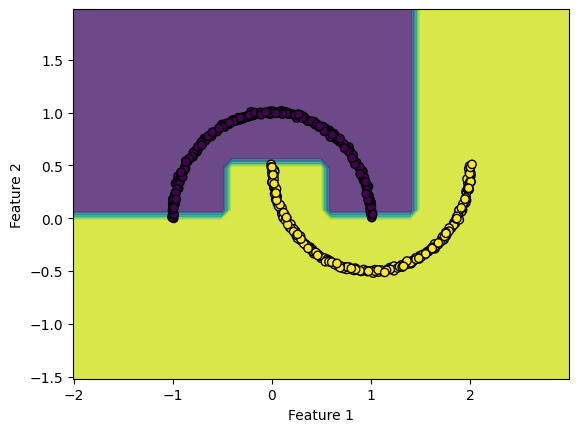

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
# Our DecisionTreeClassifier and DecisionNode classes go here ...

# Generating a synthetic 2D dataset
X, y = make_moons(n_samples=500, noise=0.01, random_state=42)

# Splitting the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Training our Decision Tree on the dataset
tree = DecisionTreeClassifier(max_depth=10)
tree.fit(X_train, y_train)

# Making predictions
y_pred = tree.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy * 100:.2f}%")

# Plotting the decision boundaries
tree.plot_decision_boundary(X, y,grid_size=.1)


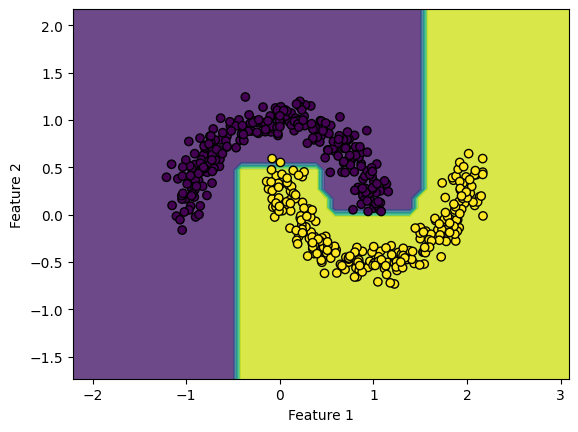

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

# Generate the dataset
X, y = make_moons(n_samples=500, noise=0.1, random_state=42)

# Splitting the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training the decision tree
clf = DecisionTreeClassifier(max_depth=10, random_state=42)
clf.fit(X_train, y_train)

# Plotting the decision boundary
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()
